In [1]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure, ColumnDataSource, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma11, Viridis11
from bokeh.util.hex import hexbin
from bokeh.layouts import gridplot
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from ei import topology_of, EI_of_layer
from TimeSeriesEI import CalculateNetworkEI

Loading BokehJS ...

# Let's first replicate the simplest plot in the paper

In [2]:
singleton = nn.Linear(1, 1, bias=False)
top = topology_of(singleton, torch.zeros((1, 1)))

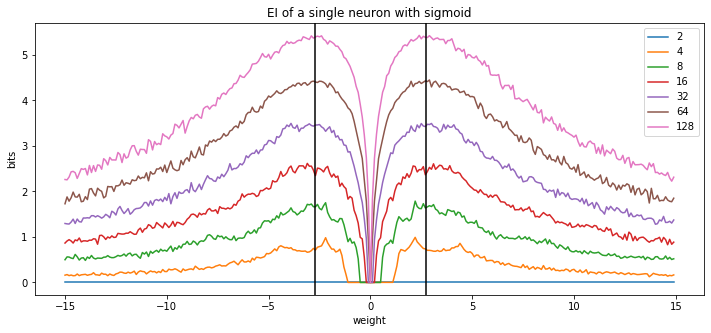

In [4]:
plt.figure(figsize=(12, 5))

ws = np.arange(-15, 15, 0.1)
for b in [2, 4, 8, 16, 32, 64, 128]:
    eis = []
    for w in ws:
        singleton.weight.data[0][0] = w
        eis.append(EI_of_layer(singleton, top, samples=1000, bins=b, activation=torch.sigmoid))
    plt.plot(ws, eis, label=str(b))
    
plt.axvline(np.e, color='black')
plt.axvline(-np.e, color='black')

plt.title("EI of a single neuron with sigmoid")
plt.xlabel("weight")
plt.ylabel("bits")
plt.legend()

# Now let's see how our two methods differ:

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


In [6]:
network = nn.Sequential(nn.Linear(784, 10, bias=False), nn.Sigmoid()).to(device)
layer, _ = network
top = topology_of(layer, torch.zeros(1, 784).to(device))
ss = [100, 500, 1000, 5000, 10000, 20000, 30000]
my_eis = []
hoel_eis = []
for s in ss:
    print("samples: {}".format(s))
    print("MY WAY:")
    my_ei = EI_of_layer(layer, top, samples=s, batch_size=40, bins=16, device=device)
    print(my_ei)
    my_eis.append(my_ei)
    print("THEIR WAY:")
    input = torch.zeros((s, 784)).to(device)
    hoel_ei, _ = CalculateNetworkEI(network, input, size=s, bins=16, device=device)
    print(hoel_ei)
    hoel_eis.append(hoel_ei)

samples: 100
MY WAY:
2467.759018242659
THEIR WAY:
2668.537645797364
samples: 500
MY WAY:
663.4740545128155
THEIR WAY:
636.1300897194213
samples: 1000
MY WAY:
338.7826011251944
THEIR WAY:
336.68622804083043
samples: 5000
MY WAY:
80.88810826423341
THEIR WAY:
82.34686491015893
samples: 10000
MY WAY:
44.186379305364845
THEIR WAY:
45.19778236544416
samples: 20000
MY WAY:
26.618918637838377
THEIR WAY:
27.12537093167014
samples: 30000
MY WAY:
19.87269496425005
THEIR WAY:
20.225043662727806


# Now for seeing how it evolves:

In [7]:
dir_path = Path().absolute()
dataset_path = dir_path.parent.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)

print(f"Using device: {device}")

Using device: cuda


In [9]:
# ///////////////////////////////////////////
#               DEFINE `Dataset`
# ///////////////////////////////////////////
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        """We save the dataset images as torch.tensor since saving 
        the dataset in memory inside a `Dataset` object as a 
        python list or a numpy array causes a multiprocessiing-related 
        memory leak."""
        self.images, self.labels = zip(*data)
        self.images = torch.from_numpy(np.array(self.images)).to(dtype)
#        self.labels = torch.tensor(np.argmax(self.labels, axis=1)).to(torch.long)
        self.labels = torch.tensor(self.labels).to(dtype)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image, label = self.transform((image, label))
        return image, label

In [10]:
train_data = MNISTDataset(mnist[:60000])
test_data = MNISTDataset(mnist[60000:])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

## Early tests show that EI decays rapidly in a single-layer network:

In [16]:
model = nn.Sequential(nn.Linear(784, 10, bias=False), nn.Sigmoid()).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
top = topology_of(model, next(iter(test_loader))[0].to(device))
top

{Linear(in_features=784, out_features=10, bias=False): ((20, 784), (20, 10))}

In [17]:
i = 0
for sample, target in islice(train_loader, 50):
    optimizer.zero_grad()
    loss = loss_fn(model(sample.to(device)), target.to(device))
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
        with torch.no_grad():
            EI = EI_of_layer(model[0], top, samples=30000, batch_size=40, bins=16, device=device)
        print("loss: {0:.6f} | EI: {1:.3E}".format(loss, EI))
    i += 1

loss: 0.251752 | EI: 2.011E+01
loss: 0.168162 | EI: 1.668E+01
loss: 0.127160 | EI: 1.124E+01
loss: 0.108487 | EI: 7.277E+00
loss: 0.102868 | EI: 3.375E+00
loss: 0.092482 | EI: 9.870E-01
loss: 0.089827 | EI: 2.817E-01
loss: 0.086587 | EI: 2.421E-12
loss: 0.090714 | EI: 2.638E-12
loss: 0.087808 | EI: 2.555E-12


## Let's see if this is caused by the bin size being too small:

In [18]:
model = nn.Sequential(nn.Linear(784, 10, bias=False), nn.Sigmoid()).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
top = topology_of(model, next(iter(test_loader))[0].to(device))
top

{Linear(in_features=784, out_features=10, bias=False): ((20, 784), (20, 10))}

In [19]:
i = 0
for sample, target in islice(train_loader, 50):
    optimizer.zero_grad()
    loss = loss_fn(model(sample.to(device)), target.to(device))
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
        with torch.no_grad():
            EI = EI_of_layer(model[0], top, samples=300000, batch_size=40, bins=128, device=device)
        print("loss: {0:.6f} | EI: {1:.3E}".format(loss, EI))
    i += 1

loss: 0.260997 | EI: 1.020E+02
loss: 0.174722 | EI: 8.676E+01
loss: 0.123732 | EI: 5.828E+01
loss: 0.113489 | EI: 3.796E+01
loss: 0.101035 | EI: 2.619E+01
loss: 0.097606 | EI: 1.912E+01
loss: 0.094202 | EI: 1.569E+01
loss: 0.089292 | EI: 1.255E+01
loss: 0.090825 | EI: 1.193E+01
loss: 0.087022 | EI: 1.151E+01


**EI still dropped by an order of magnitude after only 50 steps**

## This happens also with Hoel's function:

In [26]:
from TimeSeriesEI import CalculateNetworkEI, ExtractLayers

In [27]:
model = nn.Sequential(nn.Linear(784, 10, bias=False), nn.Sigmoid()).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [28]:
i = 0
for sample, target in islice(train_loader, 50):
    optimizer.zero_grad()
    loss = loss_fn(model(sample.to(device)), target.to(device))
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
        with torch.no_grad():
            SIZE = 30000
            input = torch.zeros(SIZE, 784).to(device)
            EI, _ = CalculateNetworkEI(model, input, size=SIZE, bins=16)
        print("loss: {0:.6f} | EI: {1:.3E}".format(loss, EI))
    i += 1

loss: 0.242994 | EI: 2.036E+01
loss: 0.165135 | EI: 1.621E+01
loss: 0.131273 | EI: 1.089E+01
loss: 0.109180 | EI: 7.298E+00
loss: 0.099008 | EI: 2.891E+00
loss: 0.105804 | EI: 7.213E-01
loss: 0.091195 | EI: 2.007E-01
loss: 0.090625 | EI: 2.650E-12
loss: 0.094074 | EI: 2.661E-12
loss: 0.085634 | EI: 2.438E-12


## Okay so this decay seems to be really happening for single layers. What about multiple layers?

In [42]:
model = nn.Sequential(nn.Linear(784, 30, bias=False), 
                      nn.Sigmoid(),
                      nn.Linear(30, 30, bias=False),
                      nn.Sigmoid(),
                      nn.Linear(30, 10, bias=False),
                      nn.Sigmoid()).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
top = topology_of(model, next(iter(test_loader))[0].to(device))
top

{Linear(in_features=784, out_features=30, bias=False): ((20, 784), (20, 30)),
 Linear(in_features=30, out_features=30, bias=False): ((20, 30), (20, 30)),
 Linear(in_features=30, out_features=10, bias=False): ((20, 30), (20, 10))}

In [43]:
first, _, second, _, third, _ = model
print(top[first])
print(top[second])
print(top[third])

((20, 784), (20, 30))
((20, 30), (20, 30))
((20, 30), (20, 10))


In [44]:
i = 0
for sample, target in islice(train_loader, 50):
    optimizer.zero_grad()
    loss = loss_fn(model(sample.to(device)), target.to(device))
    loss.backward()
    optimizer.step()
    if i % 5 == 0:
        with torch.no_grad():
            EI_first = EI_of_layer(first, top, samples=30000, batch_size=40, bins=16, device=device)
            EI_second = EI_of_layer(second, top, samples=30000, batch_size=40, bins=16, device=device)
            EI_third = EI_of_layer(third, top, samples=30000, batch_size=40, bins=16, device=device)
        print("loss: {0:.6f} | EI1: {1:.3E} | EI2: {2:.3E} | EI3: {3:.3E} ".format(loss, EI_first, EI_second, EI_third))
    i += 1

loss: 0.276183 | EI1: 6.073E+01 | EI2: 2.008E+01 | EI3: 6.552E+00 
loss: 0.255935 | EI1: 5.224E+01 | EI2: 2.011E+01 | EI3: 6.571E+00 
loss: 0.246032 | EI1: 3.741E+01 | EI2: 2.016E+01 | EI3: 6.634E+00 
loss: 0.226714 | EI1: 2.605E+01 | EI2: 2.011E+01 | EI3: 6.605E+00 
loss: 0.209210 | EI1: 1.402E+01 | EI2: 2.011E+01 | EI3: 6.555E+00 
loss: 0.197325 | EI1: 1.049E+01 | EI2: 2.017E+01 | EI3: 6.588E+00 
loss: 0.185576 | EI1: 8.999E+00 | EI2: 2.014E+01 | EI3: 6.642E+00 
loss: 0.173061 | EI1: 9.621E+00 | EI2: 2.008E+01 | EI3: 6.604E+00 
loss: 0.161476 | EI1: 9.998E+00 | EI2: 2.010E+01 | EI3: 6.610E+00 
loss: 0.151257 | EI1: 9.389E+00 | EI2: 1.999E+01 | EI3: 6.635E+00 


**It looks like the EI decay occurs only for the first layer**

## Let's do a full training run now:

In [ ]:
model = nn.Sequential(nn.Linear(784, 30, bias=False), 
                      nn.Sigmoid(),
                      nn.Linear(30, 30, bias=False),
                      nn.Sigmoid(),
                      nn.Linear(30, 10, bias=False),
                      nn.Sigmoid()).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
top = topology_of(model, next(iter(test_loader))[0].to(device))
print(top)
first, _, second, _, third, _ = model

In [47]:
# --- MATPLOTLIB DATA ---
num_batches_data = []
eis_data = [] # [(layer1, layer2, layer3), ...]
losses_data = [] #[(train, test), (train, test), ...]
accuracies_data = []

def update_metrics(num_batches):
    with torch.no_grad():
        EI_first = EI_of_layer(first, top, samples=50000, batch_size=40, bins=16, device=device)
        EI_second = EI_of_layer(second, top, samples=50000, batch_size=40, bins=16, device=device)
        EI_third = EI_of_layer(third, top, samples=50000, batch_size=40, bins=16, device=device)
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(test_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    test_loss = loss / outof
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(train_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    training_loss = loss / outof
    
    outof = 0
    accuracy = 0
    with torch.no_grad():
        for x, labels in test_loader:
            output = model(x.to(device))
            _, pred = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            accuracy += (pred == labels.to(device)).sum().item()
            outof += len(labels)
    accuracy = accuracy / outof

    
    num_batches_data.append(num_batches)
    eis_data.append((EI_first, EI_second, EI_third))
    losses_data.append((training_loss, test_loss))
    accuracies_data.append(accuracy)
    
    if num_batches % 3000 == 0:
        print("accuracy: {0:.4f} | EI1: {1:.3E} | EI2: {2:.3E} | EI3: {3:.3E} ".format(accuracy, EI_first, EI_second, EI_third))
    
# --- TRAIN ---

num_batches = 0
for epoch in range(20): 
    for sample, target in train_loader: # 3000 batches per epoch * 20 epochs = 60000 total batches
        optimizer.zero_grad()
        loss = loss_fn(model(sample.to(device)), target.to(device))
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 500 == 0:
            update_metrics(num_batches)

accuracy: 0.9016 | EI1: 2.332E+01 | EI2: 2.440E+01 | EI3: 6.077E+00 
accuracy: 0.9270 | EI1: 2.138E+01 | EI2: 2.404E+01 | EI3: 4.019E+00 
accuracy: 0.9418 | EI1: 1.885E+01 | EI2: 2.397E+01 | EI3: 3.267E+00 
accuracy: 0.9483 | EI1: 1.997E+01 | EI2: 2.390E+01 | EI3: 2.813E+00 
accuracy: 0.9524 | EI1: 1.948E+01 | EI2: 2.376E+01 | EI3: 2.598E+00 
accuracy: 0.9550 | EI1: 2.221E+01 | EI2: 2.365E+01 | EI3: 2.390E+00 
accuracy: 0.9562 | EI1: 2.358E+01 | EI2: 2.335E+01 | EI3: 2.295E+00 
accuracy: 0.9587 | EI1: 2.401E+01 | EI2: 2.320E+01 | EI3: 2.130E+00 
accuracy: 0.9594 | EI1: 2.437E+01 | EI2: 2.320E+01 | EI3: 2.033E+00 
accuracy: 0.9613 | EI1: 2.593E+01 | EI2: 2.302E+01 | EI3: 1.962E+00 
accuracy: 0.9611 | EI1: 2.531E+01 | EI2: 2.306E+01 | EI3: 1.897E+00 
accuracy: 0.9626 | EI1: 2.459E+01 | EI2: 2.295E+01 | EI3: 1.854E+00 
accuracy: 0.9634 | EI1: 2.413E+01 | EI2: 2.291E+01 | EI3: 1.796E+00 
accuracy: 0.9625 | EI1: 2.454E+01 | EI2: 2.273E+01 | EI3: 1.721E+00 
accuracy: 0.9635 | EI1: 2.565E+01 

In [53]:
EIs_layer1, EIs_layer2, EIs_layer3 = zip(*eis_data)
train_loss_data, test_loss_data = zip(*losses_data)

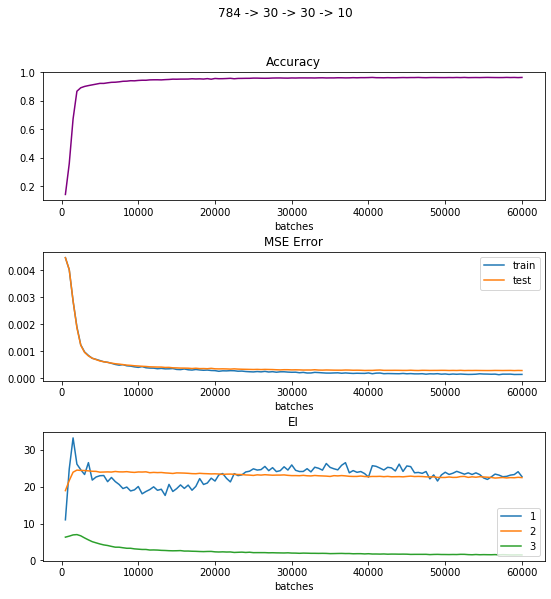

In [69]:
plt.figure(figsize=(9,9))

plt.suptitle("784 -> 30 -> 30 -> 10")

plt.subplot(3, 1, 1)
plt.title("Accuracy")
plt.plot(num_batches_data, accuracies_data, color='purple')
plt.xlabel("batches")

plt.subplot(3, 1, 2)
plt.title("MSE Error")
plt.plot(num_batches_data, train_loss_data, label="train")
plt.plot(num_batches_data, test_loss_data, label="test")
plt.xlabel("batches")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("EI")
plt.plot(num_batches_data, EIs_layer1, label="1")
plt.plot(num_batches_data, EIs_layer2, label="2")
plt.plot(num_batches_data, EIs_layer3, label="3")
plt.legend(loc='lower right')
plt.xlabel("batches")

plt.subplots_adjust(hspace=0.4)

In [63]:
for s in [10000, 30000, 50000, 100000, 200000, 300000]:
    EI = EI_of_layer(first, top, samples=s, batch_size=40, bins=16, device=device)
    print("Samples: {0:6d} | EI: {1:.4f}".format(s, EI))

Samples:  10000 | EI: 94.8822
Samples:  30000 | EI: 35.6922
Samples:  50000 | EI: 22.7928
Samples: 100000 | EI: 13.0178
Samples: 200000 | EI: 7.6823
Samples: 300000 | EI: 5.9460


In [64]:
EI_of_layer(first, top, samples=400000, batch_size=40, bins=16, device=device)

5.0612001179144634

In [61]:
for s in [10000, 30000, 50000, 100000, 200000, 300000]:
    EI = EI_of_layer(second, top, samples=s, batch_size=40, bins=16, device=device)
    print("Samples: {0:6d} | EI: {1:.4f}".format(s, EI))

Samples:  10000 | EI: 33.9923
Samples:  30000 | EI: 24.4427
Samples:  50000 | EI: 22.4762
Samples: 100000 | EI: 21.0392
Samples: 200000 | EI: 20.3323
Samples: 300000 | EI: 20.0776


In [62]:
for s in [10000, 30000, 50000, 100000, 200000, 300000]:
    EI = EI_of_layer(second, top, samples=s, batch_size=40, bins=16, device=device)
    print("Samples: {0:6d} | EI: {1:.4f}".format(s, EI))

Samples:  10000 | EI: 34.3014
Samples:  30000 | EI: 24.4656
Samples:  50000 | EI: 22.5184
Samples: 100000 | EI: 21.0633
Samples: 200000 | EI: 20.2968
Samples: 300000 | EI: 20.0475


### It looks like the EI in the last two layers was somewhat accurate, but the first layer was off by at least a factor of 4. I'd like to see now whether a more accurate estimation of EI in the first layer gives the curve a different shape

**Reinitialize the model and try again:**

In [70]:
model = nn.Sequential(nn.Linear(784, 30, bias=False), 
                      nn.Sigmoid(),
                      nn.Linear(30, 30, bias=False),
                      nn.Sigmoid(),
                      nn.Linear(30, 10, bias=False),
                      nn.Sigmoid()).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
top = topology_of(model, next(iter(test_loader))[0].to(device))
print(top)
first, _, second, _, third, _ = model

{Linear(in_features=784, out_features=30, bias=False): ((20, 784), (20, 30)), Linear(in_features=30, out_features=30, bias=False): ((20, 30), (20, 30)), Linear(in_features=30, out_features=10, bias=False): ((20, 30), (20, 10))}


In [71]:
batches_data_accurate = []
eis_first_accurate = []

num_batches = 0
for epoch in range(20): 
    for sample, target in train_loader: # 3000 batches per epoch * 20 epochs = 60000 total batches
        optimizer.zero_grad()
        loss = loss_fn(model(sample.to(device)), target.to(device))
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 500 == 0:
            with torch.no_grad():
                EI = EI_of_layer(first, top, samples=200000, batch_size=40, bins=16, device=device)
            batches_data_accurate.append(num_batches)
            eis_first_accurate.append(EI)
    print("epoch {}/{}".format(epoch+1, 20))

epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20


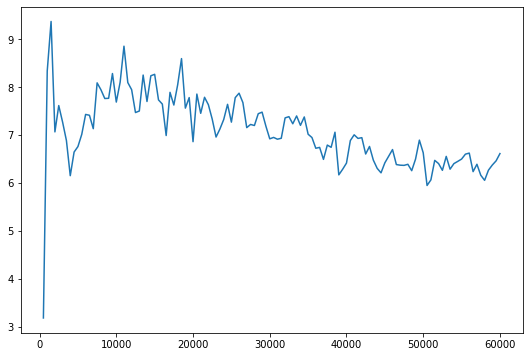

In [73]:
plt.figure(figsize=(9,6))
plt.plot(batches_data_accurate, eis_first_accurate)

**Interesting! Similar to the less-accurate EI curve, we see a sharp rise and fall at the beginning. However, the critical point here occurs much earlier. This suggests that we should not use an innaccurate EI value, since the shape will depend on the accuracy of the value. For some layers, 30000 samples won't get us nearly close enough.**

## Lastly, let's replicate the architecture from the paper: 784 -> 50 -> 30 -> 30 -> 10

In [74]:
model = nn.Sequential(nn.Linear(784, 50, bias=False), 
                      nn.Sigmoid(),
                      nn.Linear(50, 30, bias=False),
                      nn.Sigmoid(),
                      nn.Linear(30, 30, bias=False),
                      nn.Sigmoid(),
                      nn.Linear(30, 10, bias=False),
                      nn.Sigmoid()).to(device)
# loss_fn = nn.NLLLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
top = topology_of(model, next(iter(test_loader))[0].to(device))
print(top)
first, _, second, _, third, _, fourth, _ = model

{Linear(in_features=784, out_features=50, bias=False): ((20, 784), (20, 50)), Linear(in_features=50, out_features=30, bias=False): ((20, 50), (20, 30)), Linear(in_features=30, out_features=30, bias=False): ((20, 30), (20, 30)), Linear(in_features=30, out_features=10, bias=False): ((20, 30), (20, 10))}


In [75]:
# --- MATPLOTLIB DATA ---
num_batches_data = []
eis_data = [] # [(layer1, layer2, layer3, layer4), ...]
losses_data = [] #[(train, test), (train, test), ...]
accuracies_data = []

def update_metrics(num_batches):
    with torch.no_grad():
        EI_first = EI_of_layer(first, top, samples=200000, batch_size=40, bins=16, device=device)
        EI_second = EI_of_layer(second, top, samples=70000, batch_size=40, bins=16, device=device)
        EI_third = EI_of_layer(third, top, samples=50000, batch_size=40, bins=16, device=device)
        EI_fourth = EI_of_layer(fourth, top, samples=50000, batch_size=40, bins=16, device=device)
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(test_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    test_loss = loss / outof
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(train_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    training_loss = loss / outof
    
    outof = 0
    accuracy = 0
    with torch.no_grad():
        for x, labels in test_loader:
            output = model(x.to(device))
            _, pred = torch.max(output, 1)
            _, labels = torch.max(labels, 1)
            accuracy += (pred == labels.to(device)).sum().item()
            outof += len(labels)
    accuracy = accuracy / outof

    
    num_batches_data.append(num_batches)
    eis_data.append((EI_first, EI_second, EI_third, EI_fourth))
    losses_data.append((training_loss, test_loss))
    accuracies_data.append(accuracy)
    
    if num_batches % 3000 == 0:
        print("accuracy: {0:.4f} | EI1: {1:.3E} | EI2: {2:.3E} | EI3: {3:.3E} |  EI4: {4:.3E}".format(accuracy, EI_first, EI_second, EI_third, EI_fourth))
    
# --- TRAIN ---

num_batches = 0
for epoch in range(20): 
    for sample, target in train_loader: # 3000 batches per epoch * 20 epochs = 60000 total batches
        optimizer.zero_grad()
        loss = loss_fn(model(sample.to(device)), target.to(device))
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 500 == 0:
            update_metrics(num_batches)

accuracy: 0.7849 | EI1: 9.571E+00 | EI2: 2.447E+01 | EI3: 2.340E+01 |  EI4: 5.982E+00
accuracy: 0.9233 | EI1: 8.415E+00 | EI2: 2.406E+01 | EI3: 2.376E+01 |  EI4: 2.923E+00
accuracy: 0.9407 | EI1: 7.996E+00 | EI2: 2.407E+01 | EI3: 2.427E+01 |  EI4: 2.274E+00
accuracy: 0.9495 | EI1: 7.717E+00 | EI2: 2.387E+01 | EI3: 2.441E+01 |  EI4: 1.993E+00
accuracy: 0.9520 | EI1: 7.499E+00 | EI2: 2.397E+01 | EI3: 2.427E+01 |  EI4: 1.727E+00
accuracy: 0.9545 | EI1: 7.529E+00 | EI2: 2.386E+01 | EI3: 2.430E+01 |  EI4: 1.687E+00
accuracy: 0.9565 | EI1: 7.277E+00 | EI2: 2.381E+01 | EI3: 2.431E+01 |  EI4: 1.594E+00
accuracy: 0.9607 | EI1: 7.179E+00 | EI2: 2.375E+01 | EI3: 2.436E+01 |  EI4: 1.532E+00
accuracy: 0.9586 | EI1: 7.335E+00 | EI2: 2.383E+01 | EI3: 2.424E+01 |  EI4: 1.479E+00
accuracy: 0.9592 | EI1: 7.284E+00 | EI2: 2.372E+01 | EI3: 2.415E+01 |  EI4: 1.407E+00
accuracy: 0.9585 | EI1: 7.172E+00 | EI2: 2.367E+01 | EI3: 2.418E+01 |  EI4: 1.352E+00
accuracy: 0.9607 | EI1: 7.306E+00 | EI2: 2.364E+01 | E

In [76]:
EIs_layer1, EIs_layer2, EIs_layer3, EIs_layer4 = zip(*eis_data)
train_loss_data, test_loss_data = zip(*losses_data)

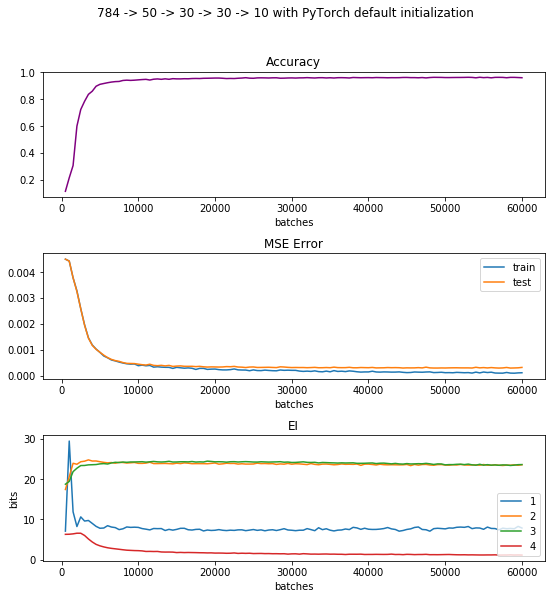

In [81]:
plt.figure(figsize=(9,9))

plt.suptitle("784 -> 50 -> 30 -> 30 -> 10 with PyTorch default initialization")

plt.subplot(3, 1, 1)
plt.title("Accuracy")
plt.plot(num_batches_data, accuracies_data, color='purple')
plt.xlabel("batches")

plt.subplot(3, 1, 2)
plt.title("MSE Error")
plt.plot(num_batches_data, train_loss_data, label="train")
plt.plot(num_batches_data, test_loss_data, label="test")
plt.xlabel("batches")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("EI")
plt.plot(num_batches_data, EIs_layer1, label="1")
plt.plot(num_batches_data, EIs_layer2, label="2")
plt.plot(num_batches_data, EIs_layer3, label="3")
plt.plot(num_batches_data, EIs_layer4, label="4")
plt.legend(loc='lower right')
plt.xlabel("batches")
plt.ylabel("bits")

plt.subplots_adjust(hspace=0.45)
plt.savefig("ei-by-layer-replication", dpi=300)